https://github.com/topics/customer-churn-prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
import os
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import shap
shap.initjs()

In [2]:
from sklearn.model_selection import StratifiedKFold


In [3]:
pd.set_option('display.max_columns',100)

In [4]:
os.listdir()

['.git',
 '.ipynb_checkpoints',
 'catboost_info',
 'customer_churn_model.ipynb',
 'README.md',
 'Telco-Customer-Churn.csv']

In [5]:
data=pd.read_csv("Telco-Customer-Churn.csv")

In [6]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [8]:
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [9]:
data["TotalCharges"]=pd.to_numeric(data["TotalCharges"], errors='coerce')

In [10]:
data[data["TotalCharges"].isna()==True]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [11]:
data["TotalCharges"].fillna(int(data["TotalCharges"].mean()), inplace=True)

In [12]:
data=data.drop(["customerID"],axis=1)

In [13]:
data.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [14]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2283.299972
std,0.368612,24.559481,30.090047,2265.000258
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1400.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


In [15]:
data["Churn"].value_counts()


No     5174
Yes    1869
Name: Churn, dtype: int64

In [16]:
categorical=list(data.dtypes[data.dtypes=="object"].index.values)
categorical

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [17]:
cat_data=data[categorical]

In [18]:
numerical=list(data.dtypes[data.dtypes!="object"].index.values)
numerical

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

In [19]:
cat_len=data[categorical].nunique().reset_index()
cat_len.columns=["column",'unique_count']
cat_len

,column,unique_count
0,gender,2
1,Partner,2
2,Dependents,2
3,PhoneService,2
4,MultipleLines,3
5,InternetService,3
6,OnlineSecurity,3
7,OnlineBackup,3
8,DeviceProtection,3
9,TechSupport,3


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 [Text(0, 0, 'customerID'),
  Text(1, 0, 'gender'),
  Text(2, 0, 'Partner'),
  Text(3, 0, 'Dependents'),
  Text(4, 0, 'PhoneService'),
  Text(5, 0, 'MultipleLines'),
  Text(6, 0, 'InternetService'),
  Text(7, 0, 'OnlineSecurity'),
  Text(8, 0, 'OnlineBackup'),
  Text(9, 0, 'DeviceProtection'),
  Text(10, 0, 'TechSupport'),
  Text(11, 0, 'StreamingTV'),
  Text(12, 0, 'StreamingMovies'),
  Text(13, 0, 'Contract'),
  Text(14, 0, 'PaperlessBilling'),
  Text(15, 0, 'PaymentMethod'),
  Text(16, 0, 'Churn')])

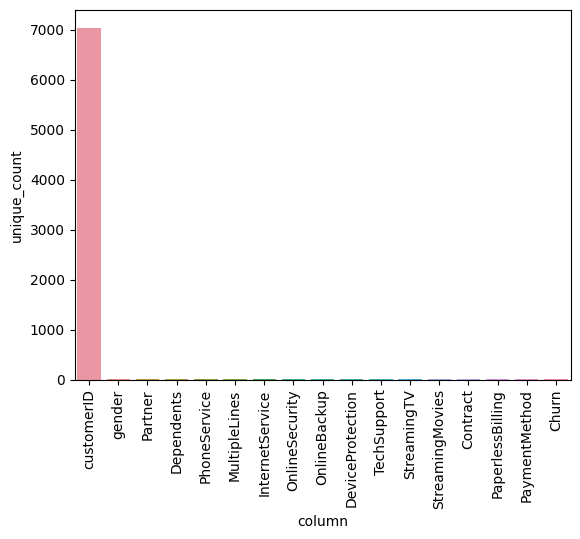

In [87]:
sns.barplot(x="column",y="unique_count",data=cat_len)
plt.xticks(rotation=90)

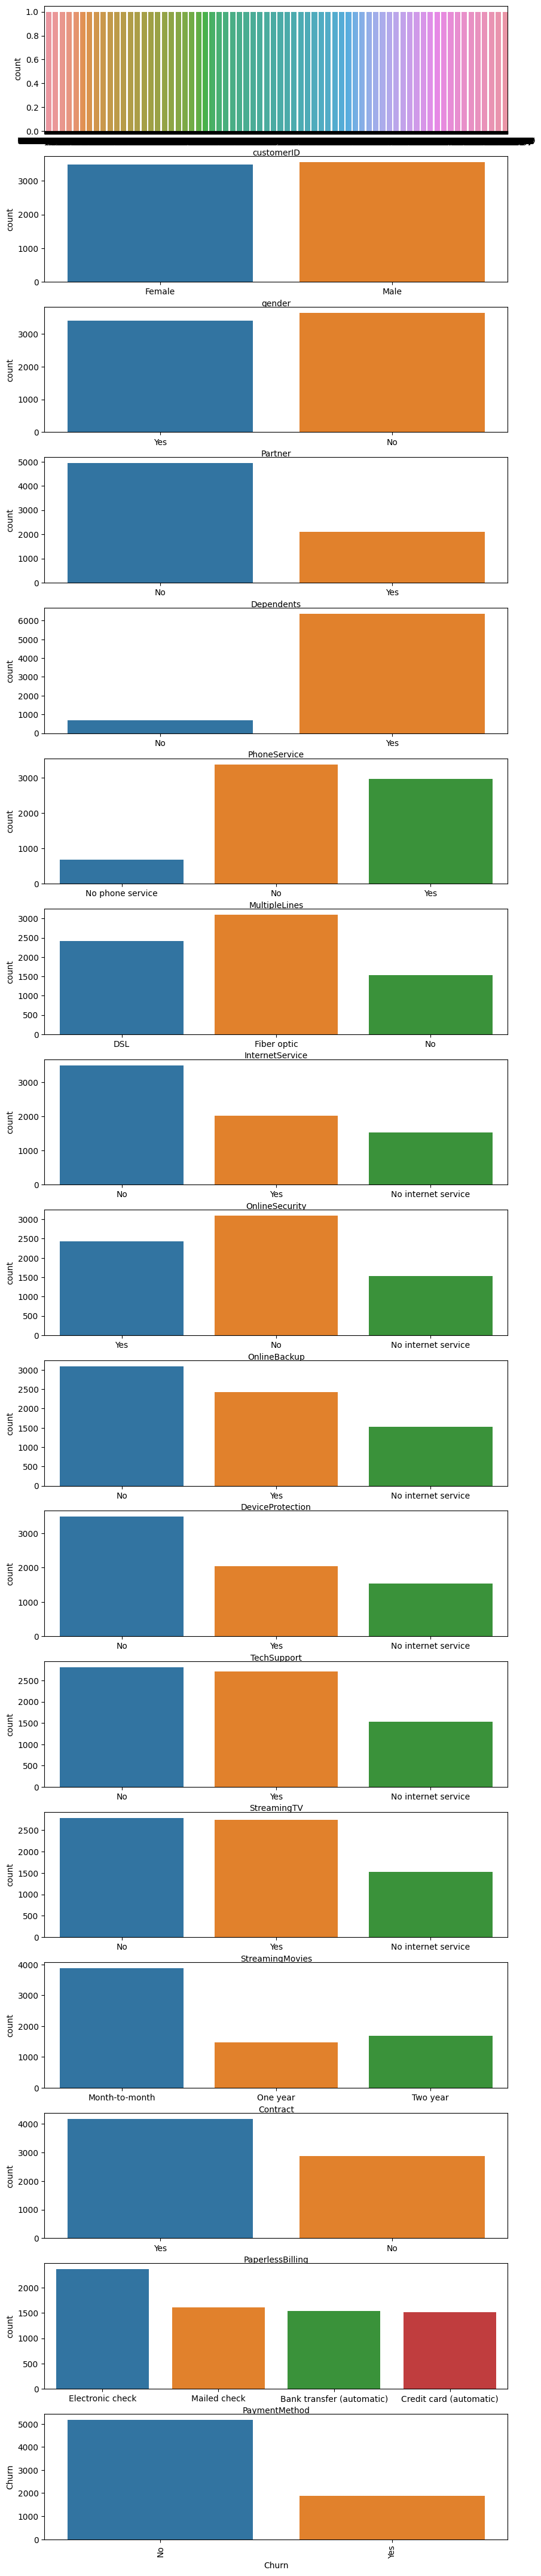

In [88]:
rows=len(categorical)
fig,axes=plt.subplots(rows,1,figsize=(10, 55))
i=0
for cat in categorical:
    sns.countplot(x=cat,data=cat_data,ax=axes[i])
    plt.xticks(rotation=90)
    plt.ylabel(cat)
    i+=1

In [ ]:
rows=len(categorical)
fig,axes=plt.subplots(rows,1,figsize=(15, 55))
i=0
for cat in categorical:
    sns.countplot(x=cat,data=cat_data,ax=axes[i],hue="Churn")
    plt.xticks(rotation=90)
    plt.ylabel(cat)
    i+=1

Error in callback <function _draw_all_if_interactive at 0x000001E3F0002950> (for post_execute):


KeyboardInterrupt: 

In [ ]:
 for column in categorical:
        if data[column].nunique()==2:
            print(column,data[column].unique())

In [20]:
def label_encoding(data,columns):
    label_encoder = LabelEncoder()
    for column in columns:
        if data[column].nunique()==2:
            data[column]= label_encoder.fit_transform(data[column])
            print(column,data[column].unique())
    return data
data=label_encoding(data,categorical)            

gender [0 1]
Partner [1 0]
Dependents [0 1]
PhoneService [0 1]
PaperlessBilling [1 0]
Churn [0 1]


In [21]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,1,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0
2,1,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,1,0,0,0,45,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,0,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1


In [22]:
cols2 = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in cols2:
    data[col] = data[col].map({'No internet service': 0, 'No': 0, 'Yes': 1})
    

In [23]:
data["MultipleLines"] = data["MultipleLines"].map({'No phone service': 0, 'No': 0, 'Yes': 1})

In [24]:
data= pd.get_dummies(data, columns=['InternetService', 'Contract', 'PaymentMethod'], drop_first=True)

In [25]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,29.85,29.85,0,0,0,0,0,0,1,0
1,1,0,0,0,34,1,0,1,0,1,0,0,0,0,56.95,1889.50,0,0,0,1,0,0,0,1
2,1,0,0,0,2,1,0,1,1,0,0,0,0,1,53.85,108.15,1,0,0,0,0,0,0,1
3,1,0,0,0,45,0,0,1,0,1,1,0,0,0,42.30,1840.75,0,0,0,1,0,0,0,0
4,0,0,0,0,2,1,0,0,0,0,0,0,0,1,70.70,151.65,1,1,0,0,0,0,1,0


In [26]:
X=data.drop(["Churn"],axis=1)
y=data["Churn"]

In [27]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
X_res, y_res = sm.fit_resample(X, y)

In [28]:
X_res.shape

(10348, 23)

In [31]:
y_res.value_counts()

0    5174
1    5174
Name: Churn, dtype: int64

In [27]:
#cat_features=list(X.dtypes[X.dtypes=="object"].index.values)

In [28]:
#X_train,X_test,y_train,y_test=train_test_split(X,y)

In [32]:

clf = CatBoostClassifier(
    iterations=5, 
    learning_rate=0.1, 
    loss_function='CrossEntropy'
)

In [33]:
sk_folds = StratifiedKFold(n_splits = 10)
f1_scores = cross_val_score(clf, X_res, y_res, cv = sk_folds,scoring="f1")

0:	learn: 0.6316003	total: 186ms	remaining: 744ms
1:	learn: 0.5865331	total: 192ms	remaining: 287ms
2:	learn: 0.5511028	total: 197ms	remaining: 131ms
3:	learn: 0.5225492	total: 202ms	remaining: 50.6ms
4:	learn: 0.5022973	total: 208ms	remaining: 0us
0:	learn: 0.6314980	total: 5.74ms	remaining: 22.9ms
1:	learn: 0.5874759	total: 11.3ms	remaining: 16.9ms
2:	learn: 0.5520839	total: 16.3ms	remaining: 10.9ms
3:	learn: 0.5239088	total: 21.6ms	remaining: 5.39ms
4:	learn: 0.5016241	total: 26.8ms	remaining: 0us
0:	learn: 0.6295551	total: 5.61ms	remaining: 22.4ms
1:	learn: 0.5826469	total: 10.8ms	remaining: 16.3ms
2:	learn: 0.5472253	total: 16ms	remaining: 10.7ms
3:	learn: 0.5194168	total: 21ms	remaining: 5.24ms
4:	learn: 0.4972862	total: 26.1ms	remaining: 0us
0:	learn: 0.6334426	total: 5.76ms	remaining: 23ms
1:	learn: 0.5884437	total: 11.2ms	remaining: 16.8ms
2:	learn: 0.5529392	total: 16.5ms	remaining: 11ms
3:	learn: 0.5262235	total: 21.7ms	remaining: 5.42ms
4:	learn: 0.5054713	total: 26.8ms	rem

In [34]:
print("Cross Validation Scores: ", f1_scores)
print("Average CV Score: ", f1_scores.mean())
print("Number of CV Scores used in Average: ", len(f1_scores))

Cross Validation Scores:  [0.74045054 0.7698335  0.71943888 0.79584121 0.85405405 0.83333333
 0.85438596 0.8573991  0.84854015 0.85921889]
Average CV Score:  0.8132495616185451
Number of CV Scores used in Average:  10


In [35]:
sk_folds = StratifiedKFold(n_splits = 10)
roc_scores = cross_val_score(clf, X, y, cv = sk_folds,scoring="roc_auc")

0:	learn: 0.6283515	total: 5.47ms	remaining: 21.9ms
1:	learn: 0.5867973	total: 9.78ms	remaining: 14.7ms
2:	learn: 0.5493878	total: 14.2ms	remaining: 9.47ms
3:	learn: 0.5217555	total: 18.7ms	remaining: 4.66ms
4:	learn: 0.5004519	total: 23ms	remaining: 0us
0:	learn: 0.6278171	total: 4.76ms	remaining: 19ms
1:	learn: 0.5874761	total: 9.32ms	remaining: 14ms
2:	learn: 0.5531668	total: 14ms	remaining: 9.31ms
3:	learn: 0.5247444	total: 18.6ms	remaining: 4.64ms
4:	learn: 0.5029576	total: 23.3ms	remaining: 0us
0:	learn: 0.6269411	total: 4.4ms	remaining: 17.6ms
1:	learn: 0.5856516	total: 8.92ms	remaining: 13.4ms
2:	learn: 0.5478225	total: 13.7ms	remaining: 9.14ms
3:	learn: 0.5212584	total: 18.1ms	remaining: 4.54ms
4:	learn: 0.4991385	total: 22.7ms	remaining: 0us
0:	learn: 0.6300160	total: 4.34ms	remaining: 17.4ms
1:	learn: 0.5860960	total: 8.84ms	remaining: 13.3ms
2:	learn: 0.5482778	total: 13.1ms	remaining: 8.71ms
3:	learn: 0.5204394	total: 17.6ms	remaining: 4.39ms
4:	learn: 0.5000709	total: 22m

In [36]:
print("Cross Validation Scores: ", roc_scores)
print("Average CV Score: ", roc_scores.mean())
print("Number of CV Scores used in Average: ", len(roc_scores))

Cross Validation Scores:  [0.83822497 0.86262982 0.85050998 0.85115934 0.82404659 0.81989367
 0.83670187 0.82242783 0.83440044 0.83204729]
Average CV Score:  0.8372041793242323
Number of CV Scores used in Average:  10


In [37]:
X_train,X_test,y_train,y_test=train_test_split(X_res,y_res)

In [38]:




clf.fit(X_train, y_train, 
        
        eval_set=(X_test, y_test), 
        verbose=False
)

print('CatBoost model is fitted: ' + str(clf.is_fitted()))
print('CatBoost model parameters:')
print(clf.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 5, 'learning_rate': 0.1, 'loss_function': 'CrossEntropy'}


In [39]:

predictions=clf.predict(X_test)
conf_matrix = confusion_matrix(y_test,predictions)
conf_matrix

array([[1009,  261],
       [ 194, 1123]], dtype=int64)

In [40]:
print ("\n Classification report : \n",classification_report(y_test,predictions))


 Classification report : 
               precision    recall  f1-score   support

           0       0.84      0.79      0.82      1270
           1       0.81      0.85      0.83      1317

    accuracy                           0.82      2587
   macro avg       0.83      0.82      0.82      2587
weighted avg       0.82      0.82      0.82      2587



In [41]:
clf.feature_importances_

array([ 0.        ,  0.        ,  3.63431788,  1.54739669,  5.93938555,
        0.        ,  0.        ,  6.02142339,  2.34707548,  0.        ,
        6.08820189,  0.        ,  0.        ,  0.        ,  5.1705391 ,
        0.        ,  4.18221997, 10.84101456, 12.48774434, 29.97421349,
        5.36311048,  0.        ,  6.40335718])

In [42]:
xg_model=xgb.XGBClassifier()
xg_model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [43]:
explainer=shap.TreeExplainer(xg_model,X_train)

In [ ]:
shap_values=explainer.shap_values(X_test)

In [ ]:
explainer.expected_value

In [ ]:
y_test.iloc[1]

In [ ]:
shap.force_plot(explainer.expected_value,shap_values[1],X_test.iloc[1,:])

In [93]:
shap_values[1]

array([ 0.24240223, -0.04958005,  0.06673045,  0.0306    , -0.28331374,
       -0.04806974, -0.08289834, -0.39930853,  0.01345787,  0.03926741,
        0.11980209, -0.03338987,  0.01363255, -0.01455904,  0.77608304,
        0.46482282, -0.22364949,  0.02918459,  0.12792731,  0.52089404,
       -0.04082568, -0.10973679,  0.07636754])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


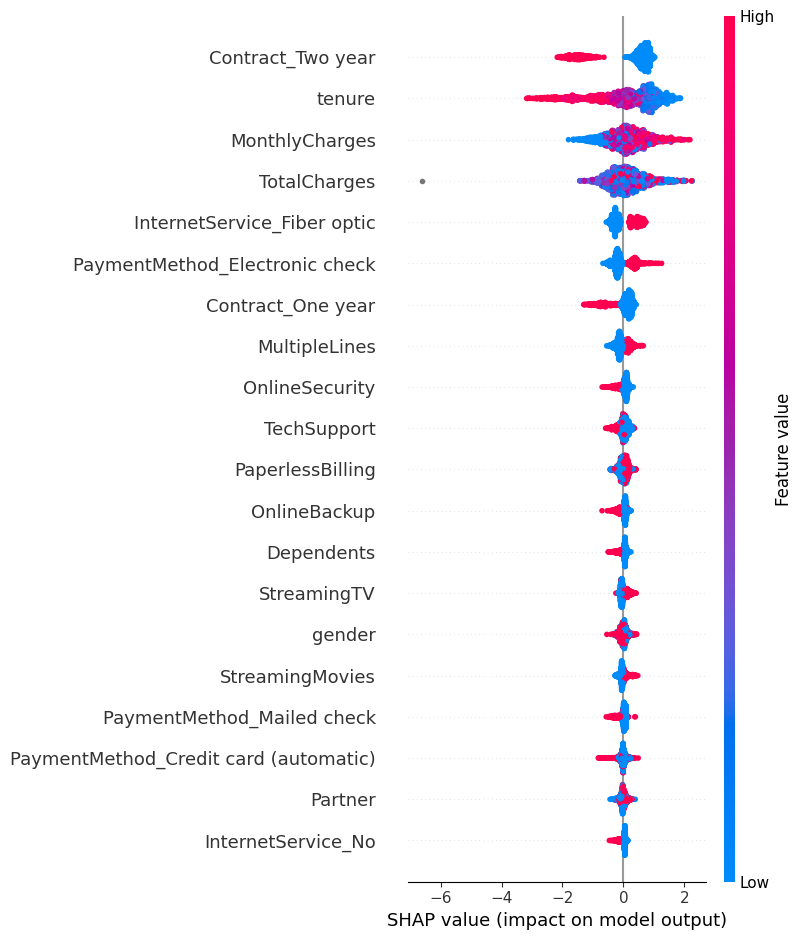

In [94]:
shap.summary_plot(shap_values, X_test)



In [88]:
shap.bar_plot(explainer.shap_values(X_test[1])[0],feature_names=X.columns,max_display=len(X.columns))

KeyError: 1

In [99]:
shap_values=explainer(X_test[:1])


In [100]:
shap_values

.values =
array([[ 0.00233831, -0.03596094, -0.04603306,  0.0574121 ,  0.11668142,
        -0.02225822,  0.08923791, -0.18510467, -0.15344453,  0.01692291,
        -0.06044962,  0.0488621 ,  0.10940597,  0.09281522, -0.61414835,
        -0.53739417,  0.52058056,  0.04552711,  0.1188349 ,  0.56124416,
        -0.04297655, -0.08734372, -0.23687619]])

.base_values =
array([-2.67818902])

.data =
array([[0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 3.40000e+01,
        1.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00,
        0.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00, 1.09800e+02,
        3.58725e+03, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00]])

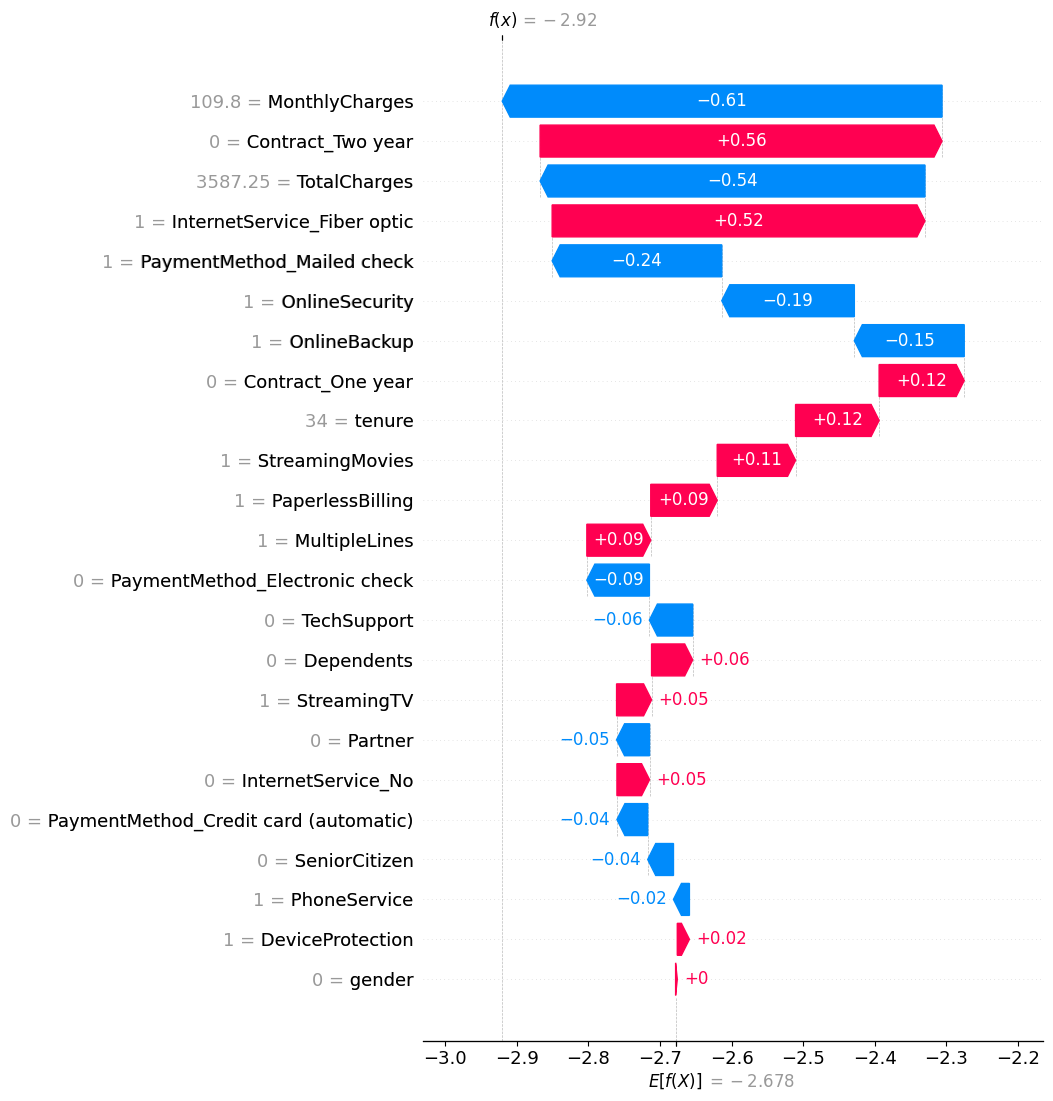

In [102]:
shap.waterfall_plot(shap_values[0],max_display=len(X.columns))